In [130]:
!pip install scikit-surprise

In [131]:
import pandas as pd; import surprise; from surprise import KNNBasic; import matplotlib.pyplot as plt; from surprise.model_selection import GridSearchCV;

In [132]:
raw_data = pd.read_csv('../Ratings/ratings_small.csv')
raw_data.drop_duplicates(inplace=True)
raw_data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [133]:
raw_data.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [134]:
raw_data = raw_data[['userId', 'movieId', 'rating']]
rating_col = raw_data['rating']
reader = surprise.Reader(rating_scale=(rating_col.min(),rating_col.max()))
data = surprise.Dataset.load_from_df(raw_data, reader)

In [135]:
import numpy as np 
#source https://www.kaggle.com/robottums/probabalistic-matrix-factorization-with-suprise
class ProbabilisticMatrixFactorization(surprise.AlgoBase):
    # Randomly initializes two Matrices, Stochastic Gradient Descent to be able to optimize the best factorization for ratings.
    def __init__(self,learning_rate,num_epochs,num_factors):
       # super(surprise.AlgoBase)
        self.alpha = learning_rate #learning rate for Stochastic Gradient Descent
        self.num_epochs = num_epochs
        self.num_factors = num_factors
    def fit(self,train):
        #randomly initialize user/item factors from a Gaussian
        P = np.random.normal(0,.1,(train.n_users,self.num_factors))
        Q = np.random.normal(0,.1,(train.n_items,self.num_factors))
        #print('fit')

        for epoch in range(self.num_epochs):
            for u,i,r_ui in train.all_ratings():
                residual = r_ui - np.dot(P[u],Q[i])
                temp = P[u,:] # we want to update them at the same time, so we make a temporary variable. 
                P[u,:] +=  self.alpha * residual * Q[i]
                Q[i,:] +=  self.alpha * residual * temp 

                
        self.P = P
        self.Q = Q

        self.trainset = train
    
    
    def estimate(self,u,i):
        #returns estimated rating for user u and item i. Prerequisite: Algorithm must be fit to training set.
        #check to see if u and i are in the train set:
        #print('gahh')

        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            #print(u,i, '\n','yep:', self.P[u],self.Q[i])
            #return scalar product of P[u] and Q[i]
            nanCheck = np.dot(self.P[u],self.Q[i])
            
            if np.isnan(nanCheck):
                return self.trainset.global_mean
            else:
                return np.dot(self.P[u,:],self.Q[i,:])
        else:# if its not known we'll return the general average. 
           # print('global mean')
            return self.trainset.global_mean
                
        

In [136]:
param_grid = {'num_epochs': [20, 25], 
              'learning_rate': [0.001, 0.1, 0.01],
              'num_factors': [5,10,20] }

p_m_f = GridSearchCV(ProbabilisticMatrixFactorization, param_grid, measures=['RMSE', 'MAE'], cv=5, n_jobs=5)
p_m_f.fit(data)

In [156]:
param_grid = {'k': [5, 10, 15, 20, 25, 30], 'user_based': [True], 'name': ['cosine', 'MSD', 'pearson']}

user_based_filtering = GridSearchCV(KNNBasic, param_grid, measures=['RMSE', 'MAE'], cv=5, n_jobs=5)
user_based_filtering.fit(data)

In [157]:
param_grid = {'k': [5, 10, 15, 20, 25, 30], 'user_based': [False], 'name': ['cosine', 'MSD', 'pearson']}

item_based_filtering = GridSearchCV(KNNBasic, param_grid, measures=['RMSE', 'MAE'], cv=5, n_jobs=5)
item_based_filtering.fit(data)

In [196]:
print(p_m_f.best_score)

{'rmse': 0.9721800346212006, 'mae': 0.7414493302453836}


In [195]:
print(user_based_filtering.best_score)

{'rmse': 0.9643373797589329, 'mae': 0.7381059518572946}


In [194]:
print(item_based_filtering.best_score)

{'rmse': 0.9636279597103437, 'mae': 0.7375786400847663}


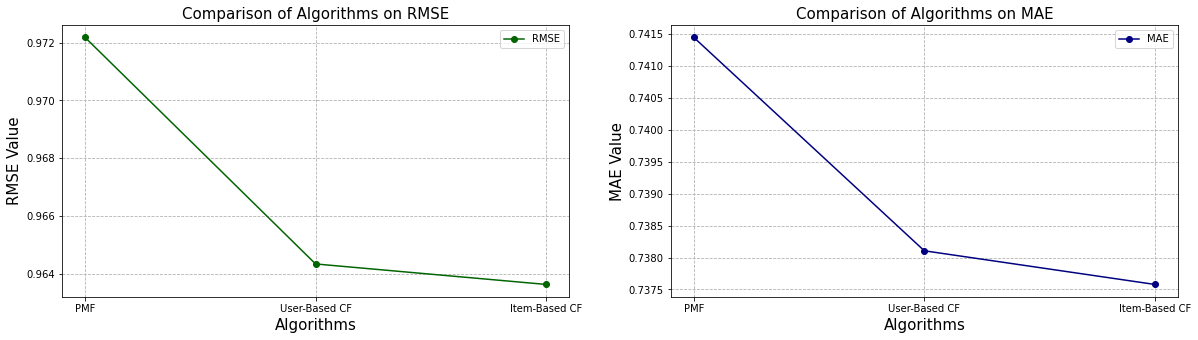

In [161]:
#D
x_algo = ['PMF', 'User-Based CF', 'Item-Based CF']
rmse_cv = [p_m_f.best_score['rmse'], user_based_filtering.best_score['rmse'], item_based_filtering.best_score['rmse']]
mae_cv = [p_m_f.best_score['mae'], user_based_filtering.best_score['mae'], item_based_filtering.best_score['mae']]

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

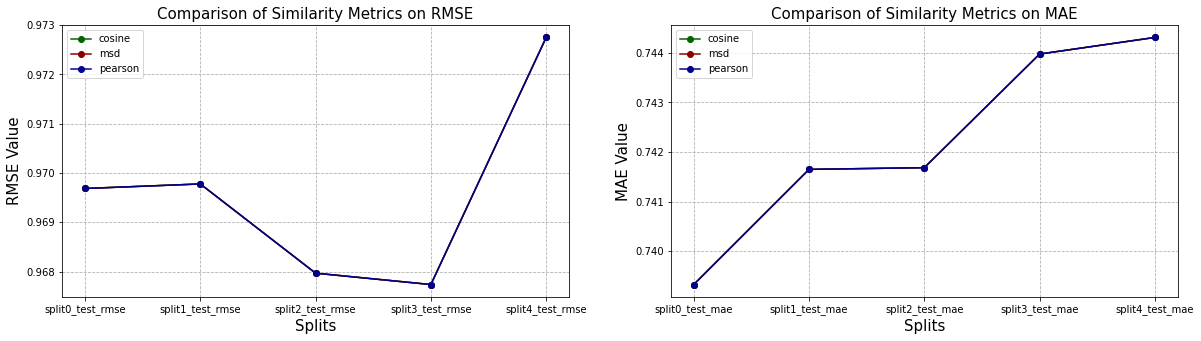

In [190]:
#E
user_based_filtering_results = pd.DataFrame.from_dict(user_based_filtering.cv_results)
item_based_filtering_results = pd.DataFrame.from_dict(item_based_filtering.cv_results)

columns_rmse = ['split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse', 'split3_test_rmse', 'split4_test_rmse']
columns_mae = ['split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae']
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Similarity Metrics on RMSE', loc='center', fontsize=15)
plt.plot(user_based_filtering_results.loc[user_based_filtering_results['param_name'] == 'cosine'][columns_rmse].mean(), label='cosine', color='darkgreen', marker='o')
plt.plot(user_based_filtering_results.loc[user_based_filtering_results['param_name'] == 'MSD'][columns_rmse].mean(), label='msd', color='darkred', marker='o')
plt.plot(user_based_filtering_results.loc[user_based_filtering_results['param_name'] == 'pearson'][columns_rmse].mean(), label='pearson', color='darkblue', marker='o')
plt.xlabel('Splits', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Similarity Metrics on MAE', loc='center', fontsize=15)
plt.plot(item_based_filtering_results.loc[user_based_filtering_results['param_name'] == 'cosine'][columns_mae].mean(), label='cosine', color='darkgreen', marker='o')
plt.plot(item_based_filtering_results.loc[user_based_filtering_results['param_name'] == 'MSD'][columns_mae].mean(), label='msd', color='darkred', marker='o')
plt.plot(item_based_filtering_results.loc[user_based_filtering_results['param_name'] == 'pearson'][columns_mae].mean(), label='pearson', color='darkblue', marker='o')
plt.xlabel('Splits', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()


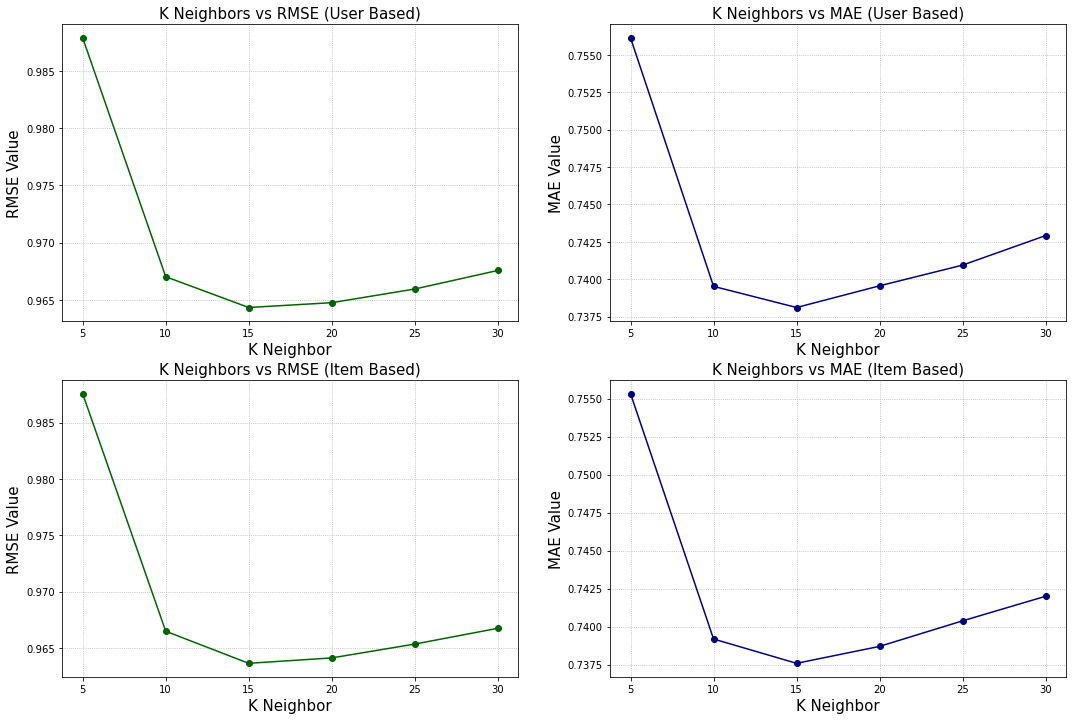

In [164]:
#F
def get_y(data):
    result = []
    for i in range(0, len(x)*3, 3):
        result.append(data[i])
    return result


x = param_grid['k']
y1 = get_y(user_based_filtering.cv_results['mean_test_rmse'])
y2 = get_y(user_based_filtering.cv_results['mean_test_mae'])
y3 = get_y(item_based_filtering.cv_results['mean_test_rmse'])
y4 = get_y(item_based_filtering.cv_results['mean_test_mae'])

plt.figure(figsize=(18,12))

plt.subplot(2, 2, 1)
plt.title('K Neighbors vs RMSE (User Based)', loc='center', fontsize=15)
plt.plot(x, y1, color='darkgreen', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.grid(ls='dotted')

plt.subplot(2, 2, 2)
plt.title('K Neighbors vs MAE (User Based)', loc='center', fontsize=15)
plt.plot(x, y2, color='navy', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.grid(ls='dotted')

plt.subplot(2, 2, 3)
plt.title('K Neighbors vs RMSE (Item Based)', loc='center', fontsize=15)
plt.plot(x, y3, color='darkgreen', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.grid(ls='dotted')

plt.subplot(2, 2, 4)
plt.title('K Neighbors vs MAE (Item Based)', loc='center', fontsize=15)
plt.plot(x, y4, color='navy', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.grid(ls='dotted')



plt.show()